# SD212: Graph mining
## Lab 2: Graph structure

In this lab, you will learn to:
* plot the degree distribution and observe the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions),
* estimate the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph and observe the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* estimate the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) of a graph.

## Import

In [3]:
from IPython.display import SVG

In [4]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [5]:
from sknetwork.data import load_netset, erdos_renyi, cyclic_graph, karate_club
from sknetwork.path import distance, diameter, shortest_path
from sknetwork.utils import bipartite2undirected
from sknetwork.topology import Triangles
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [6]:
openflights = load_netset('openflights')

Parsing files...
Done.


In [7]:
# focus on degrees, not weights
adjacency = (openflights.adjacency > 0)

In [8]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [9]:
cinema = load_netset('cinema')

Parsing files...
Done.


## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* out-degrees and in-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Compute the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and compare it to that of a Poisson distribution with the same mean.
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale and compare it to that of an equivalent [Erdos-Rényi](https://en.wikipedia.org/wiki/Erdős–Rényi_model) graph (same number of nodes, same average degree).
* Conclude: do you consider that the degree distributions of these graphs have a power law?

In [10]:
def nC2(n):
    return n*(n-1)/2

In [12]:
adjacency = wikivitals.adjacency

In [13]:
n = adjacency.shape[0]
degrees = adjacency.dot(np.ones(n)) # this is the out degree
in_degrees = adjacency.T.dot(np.ones(n))

In [20]:
np.mean(degrees)

79.11416300439473

In [23]:
np.sort(degrees)[-100:], n

(array([312., 313., 313., 314., 314., 315., 315., 315., 316., 316., 317.,
        318., 320., 320., 321., 321., 321., 322., 322., 323., 325., 325.,
        328., 328., 328., 331., 334., 334., 336., 337., 337., 338., 339.,
        340., 340., 340., 340., 341., 341., 342., 345., 346., 347., 347.,
        351., 353., 353., 356., 356., 356., 356., 357., 357., 358., 358.,
        358., 358., 363., 368., 371., 371., 372., 375., 379., 380., 380.,
        388., 389., 390., 390., 391., 391., 396., 402., 405., 405., 405.,
        406., 406., 408., 409., 412., 413., 415., 416., 426., 436., 436.,
        444., 446., 450., 452., 463., 471., 477., 525., 547., 627., 627.,
        664.]),
 10012)

In [15]:
# coefficient of variation
cv_out = np.std(degrees) / np.mean(degrees) 
cv_in = np.std(in_degrees) / np.mean(in_degrees)

cv_out, cv_in

(0.8065909718992998, 1.3553811414388752)

In [16]:
adjacency_random = erdos_renyi(n, np.mean(degrees) / (n-1))

In [17]:
degrees_random = adjacency_random.dot(np.ones(n))

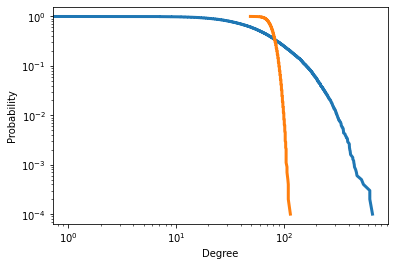

In [19]:
plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3)
plt.loglog(np.sort(degrees_random), 1 - np.arange(n) / n, lw = 3)
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.show()

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Complete the following function computing the distances from any given node in number of hops.
* Check your code with the function ``distance``.
* Give ones of the longest shortest paths starting from **Paris Charles de Gaulle** airport in Openflights.<br> 
You might use the function ``shortest_path``.<br>
List the corresponding airports and display the path.

In [29]:
def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    stop = False
    t = 0
    while not stop:
        t += 1
        reached_new = adjacency.T.dot(reached)
        # to be modified   
        stop = (reached_new==reached).all()
        distances[reached_new & ~reached] = t
        reached |= reached_new
    return distances

In [73]:
distances = get_distances(adjacency, 0)
distances

array([0., 1., 1., ..., 5., 5., 5.])

In [42]:
adjacency = openflights.adjacency > 0
n = adjacency.shape[0]
airports = openflights.names

(array([], dtype=int64),)

In [68]:
# find index of Charles de Gaulle airport
for i, airport in enumerate(airports):
    if "Charles de" in airport:
        cdg = i
        break

In [72]:
cdg, airports[cdg]

(622, 'Charles de Gaulle International Airport')

In [82]:
distancesFromCDG = get_distances(adjacency, cdg)
distancesFromCDG[:100]

array([3., 3., 3., 3., 2., 3., 3., 2., 2., 6., 4., 4., 4., 1., 3., 2., 3.,
       2., 2., 4., 3., 3., 4., 3., 3., 3., 4., 4., 4., 2., 3., 2., 4., 5.,
       3., 2., 3., 4., 2., 2., 2., 2., 3., 5., 4., 3., 2., 3., 2., 5., 3.,
       2., 2., 3., 2., 2., 3., 3., 3., 2., 3., 3., 3., 3., 1., 3., 2., 3.,
       3., 2., 3., 2., 2., 3., 3., 2., 3., 5., 3., 2., 2., 3., 6., 4., 3.,
       2., 2., 6., 1., 4., 4., 2., 5., 2., 2., 4., 2., 2., 2., 3.])

In [89]:
# reaching cdg in at most 3 flights
print(len(np.where(distancesFromCDG<4)[0]), "out of", len(distancesFromCDG))

2815 out of 3097


In [96]:
# most distant airport from cdg
idx = np.argmax(distancesFromCDG)
print(airports[idx], "is reachable with", int(distancesFromCDG[idx]), "flights from cdg")

Peawanuck Airport is reachable with 7 flights from cdg


In [74]:
np.all(distance(adjacency, 0) == distances)

True

#### Getting paths

In [101]:
def get_adjacency_path(adjacency, path):
    '''Return a path as an adjacency matrix (subset of edges).'''
    row = path[:-1]
    col = path[1:]
    data = np.ones(len(row), dtype=bool)
    adjacency_path = sparse.csr_matrix((data, (row, col)), shape=adjacency.shape)
    return adjacency_path

In [102]:
# a random shortest path
source, dest = 900, 2500
print(airports[source], '->', airports[dest])
path = shortest_path(adjacency, source, dest)

Pago Pago International Airport -> Al Ain International Airport


In [103]:
# representation as a sparse matrix
adjacency_path = get_adjacency_path(adjacency, path)

In [104]:
# display
position = openflights.position
image = svg_graph(adjacency_path, position, directed=True, height=400, width=800, 
                  node_size=1, edge_width=3, edge_color='blue')

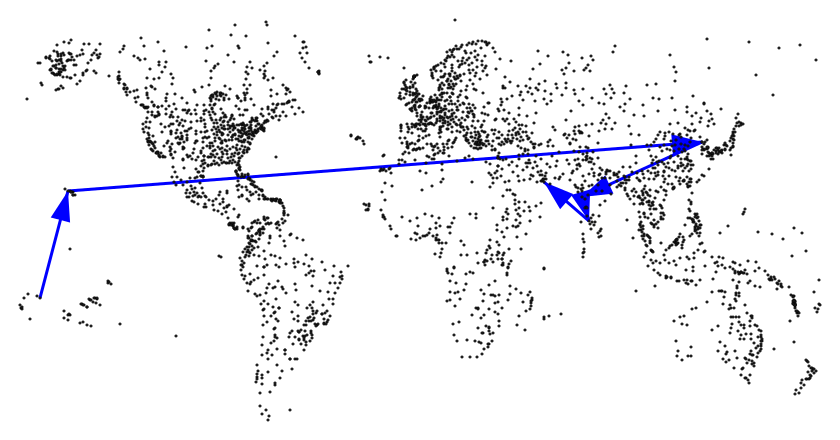

In [105]:
SVG(image)

## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [106]:
adjacency= openflights.adjacency > 0
distances = get_distances(adjacency, cdg)

In [107]:
for k in range(1, 4):
    print(k, (np.sum(distances <= k)-1) / adjacency.shape[0] * 100, "%")

1 7.523409751372295 %
2 61.866322247336136 %
3 90.86212463674524 %


In [139]:
adjacency = wikivitals.adjacency>0
sites  = wikivitals.names
for i, site in enumerate(sites):
    if "Paris" == site:
        paris = i
        break

In [119]:
paris, sites[paris]

(3279, 'Paris')

In [123]:
distances = get_distances(adjacency, paris)
for k in range(1, 4):
    print(k, "hops:", (np.sum(distances <= k)-1) / adjacency.shape[0] * 100, "%")

1 hops: 3.5457451058729523 %
2 hops: 64.79224930083899 %
3 hops: 99.30083899320815 %


## To do

The following function estimates the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph.

* Write a function giving the corresponding path (longest shortest path).
* Give a path of **length 12** in Openflights (with the airport names) and display it.
* Give a path of **length 6** in WikiVitals (with the names of the articles).

In [124]:
def estimate_diameter(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Estimate the diameter of a graph (longest shortest path).
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    diameter:
        Estimation of the diameter. 
    '''    
    n = adjacency.shape[0]
    # start from random nodes
    nodes = np.random.choice(n, size=n_samples)
    distances = distance(adjacency.T, sources=nodes)
    distances[distances == np.inf] = -1
    # get the corresponding furthest nodes
    nodes_far = distances.argmax(axis=1)    
    distances = distance(adjacency, sources=nodes_far)
    distances[distances == np.inf] = -1
    # take the longest shortest path from these nodes 
    diameter = distances.max()
    return int(diameter)

In [125]:
estimate_diameter(wikivitals.adjacency>0)

6

In [126]:
estimate_diameter(openflights.adjacency>0)

12

In [135]:
estimate_diameter(adjacency)

6

In [152]:
diameter?

Signature:
diameter(
    adjacency:Union[scipy.sparse.csr.csr_matrix, numpy.ndarray],
    n_sources:Union[float, int, NoneType]=None,
    n_jobs:Union[int, NoneType]=None,
) -> int
Docstring:
Lower bound on the diameter of a graph which is the length of the longest shortest path between two nodes.

Parameters
----------
adjacency :
    Adjacency matrix of the graph.
n_sources :
    Number of node sources to use for approximation.

    * If None, compute exact diameter.
    * If int, sample n_sample source nodes at random.
    * If float, sample (n_samples * n) source nodes at random.
n_jobs :
    If an integer value is given, denotes the number of workers to use (-1 means the maximum number will be used).
    If ``None``, no parallel computations are made.

Returns
-------
diameter : int

Examples
--------
>>> from sknetwork.data import house
>>> adjacency = house()
>>> d_exact = diameter(adjacency)
>>> d_exact
2
>>> d_approx = diameter(adjacency, 2)
>>> d_approx <= d_exact
True
>>> d_

In [151]:
def estimate_diameter_path(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Return a path of length equal to the (estimated) diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    path:
        List of nodes. 
    '''    
    # to be modified
    n = adjacency.shape[0]
    # start from random nodes
    nodes = np.random.choice(n, size=n_samples)
    distances = distance(adjacency.T, sources=nodes)
    distances[distances == np.inf] = -1
    # get the corresponding furthest nodes
    nodes_far = distances.argmax(axis=1)
    distances = distance(adjacency, sources=nodes_far)
    distances[distances == np.inf] = -1
    # get the source and dest of longest path
#     idx_src = np.where(nodes==np.argmax(distances))
#     idx_dst = np.where(nodes_far==np.argmax(distances))
#     source = nodes[idx]
#     dest = nodes_far[idx]
    source = 0
    dest = 0
    path = shortest_path(adjacency, source, dest)
    return path

In [152]:
path = estimate_diameter_path(adjacency)

In [153]:
source = 300; dest = 800
print(sites[source], "->", sites[dest])
shortest_path(adjacency, source, dest)

Music theory -> Cartilage


[300, 306, 705, 800]

## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
* Plot the corresponding histogram.
* Which fraction of actors have a Bacon number of 3 at most?

In [220]:
biadjacency = cinema.biadjacency

In [221]:
cinema.names_col, cinema.names_row

(array(['Joe E. Brown', 'Eric Blore', 'Susan Hayward', ...,
        'Olivier Saladin', 'Reona Hirota', 'Leyla Sayar'], dtype='<U95'),
 array(['$1,000 a Touchdown', '$9.99', '$', ...,
        'Šta se zgodi kad se ljubav rodi', 'Želary', '’O Re'], dtype='<U95'))

In [222]:
actors = cinema.names_col
movies = cinema.names_row

In [223]:
n_row, n_col = biadjacency.shape
n_row, n_col

(88440, 44586)

In [224]:
n = n_row + n_col
n

133026

In [225]:
{i:actor for i,actor in enumerate(actors) if 'Bacon' in actor}

{2994: 'Frank Bacon',
 3465: 'Kevin Bacon',
 4052: 'Lloyd Bacon',
 10011: 'Irving Bacon',
 18496: 'Max Bacon',
 39070: 'David Bacon'}

In [226]:
bacon = n_row + 3465 # skip the nb of films

In [227]:
adjacency = bipartite2undirected(biadjacency)

In [228]:
distances = get_distances(adjacency, bacon)
len(distances)

133026

In [229]:
bacon_numbers = distances[n_row:]

In [230]:
# for Monica Bellucci:
{i:actor for i,actor in enumerate(actors) if 'Monica Bellucci' in actor} 

{2644: 'Monica Bellucci'}

In [250]:
bacon_numbers = distances[n_row:]//2 # divided by 2 since it is a biadjacency graph
np.sort(bacon_numbers)

array([ 0.,  1.,  1., ..., 13., 13., 13.])

In [252]:
# bellucci:
bacon_numbers[2644]

2.0

In [232]:
bellucci = n_row + 2644

In [237]:
# it is more efficient to just calculate the distances from Kevin Bacon, however:
distancesBellucci = get_distances(adjacency, bellucci)
print('Monica Bellucci has a Kevin Bacon distance of', int(distancesBellucci[bacon]/2))

Monica Bellucci has a Kevin Bacon distance of 2


In [234]:
# actors with bacon distance less than 7
len(np.where(bacon_numbers <= 6)[0])/len(actors)

0.5762795496344144

(array([1.0000e+00, 2.1900e+02, 0.0000e+00, 6.6930e+03, 1.8781e+04,
        0.0000e+00, 1.4084e+04, 3.9950e+03, 0.0000e+00, 6.3200e+02,
        1.2700e+02, 0.0000e+00, 2.9000e+01, 9.0000e+00, 0.0000e+00,
        3.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00, 3.0000e+00]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ,
        14.3, 15.6, 16.9, 18.2, 19.5, 20.8, 22.1, 23.4, 24.7, 26. ]),
 <BarContainer object of 20 artists>)

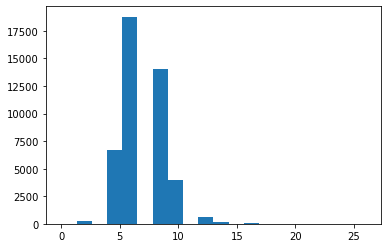

In [235]:
plt.hist(bacon_numbers, bins=20)

## 3. Clustering coefficient

The computation of the clustering coefficient of a graph is time-consuming.
You will now learn to **estimate** it.

## To do


* Complete the following function to estimate the clustering coefficient of a graph.
* Check your code on the triangle, then on the karate club graph using ``Triangles``.
* Estimate the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph) and compare with that of equivalent Erdos-Rényi graphs (same number of nodes, same average degree).

**Hint:** A triangle is... a cycle of length 3

In [207]:
def get_clustering_coefficient(adjacency: sparse.csr_matrix, n_samples: int = 100) -> float:
    '''Get the clustering coefficient of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph (binary).
    
    Returns
    -------
    clustering_coef:
        Clustering coefficient.
    '''
    clustering_coef = 0
    # sample nodes
    n = adjacency.shape[0]
    if n_samples < n:
        nodes = np.random.choice(n, size=n_samples, replace=False)
    else:
        nodes = np.arange(n)
    # compute the clustering coefficient for these samples
    # to be modified
    clustering_coef = 0
    return clustering_coef

In [208]:
triangle = cyclic_graph(3)

In [209]:
algo = Triangles()

In [210]:
algo.fit(triangle)

Triangles(parallelize=False)

In [211]:
algo.clustering_coef_

1.0

In [212]:
get_clustering_coefficient(triangle)

0

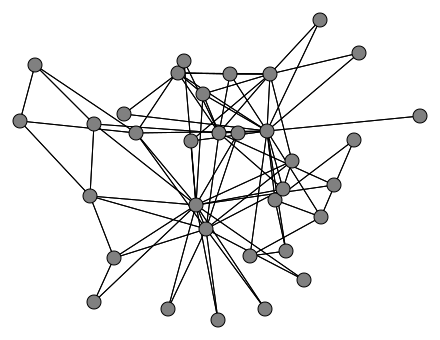

In [213]:
adjacency = karate_club()
image=svg_graph(adjacency)
SVG(image)

In [214]:
algo = Triangles()
algo.fit(adjacency)

Triangles(parallelize=False)

In [216]:
algo.clustering_coef_, algo.n_triangles_

(0.2556818181818182, 45)

In [199]:
# this is a big graph, don't show it
adjacency = wikivitals.adjacency